# SPAM/HAM detection

We would be using bouquet of algorithms to train Spam detector and compare there accuracy:

## Algorithm used.

* Naive Bayes Algorithms - 2
* SVM based Classification Algorithm.

## Steps of our SPAM/HAM algorithm

1.  Import relevant packages
2.  Import the test and training data
3.  Vectorize or featurize our test and training data.
4.  Running classification algorithms on our vectorized data
5.  Comparing the results using plots

Let's start by importing packages

In [1]:
from __future__ import print_function

import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets.base import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics

# Categories

This is two class classification problem:

1. SPAM
2. HAM

Let's define the categories and load our training dataset:

We have divided all our emails in two sets:
1. Train :  Files we would be using to train our Classification algorithm
2. Test  : Files we would be using to test accuracy of our models.

## Collection Statistics

```
 |          | Number of Spam | Number of HAM |
 | Training | 4496           | 12045         |
 | Test     | 4500           | 1500          |
```
## Directory structure of our test/train collection

Our collection is organized as follows on directory level:

~/Documents/IRLAB/MachineLearningSession/assets » ls spamham/                                       gaurav@Gaurav
test   train

~/Documents/IRLAB/MachineLearningSession/assets » ls spamham/test                                   gaurav@Gaurav
ham  spam

~/Documents/IRLAB/MachineLearningSession/assets » ls spamham/test/ham |wc -l                        gaurav@Gaurav
    1500

~/Documents/IRLAB/MachineLearningSession/assets » ls spamham/test/spam |wc -l                       gaurav@Gaurav
    4500

## Sample of a spam document
```
Subject: good day dear sir ,
good day dear customer , ! : )
very cheap pharmacy for lowest price !
meridia 75 $
prozac 70 $
viagra 64 $
xenical 70 $
celebrex 72 $
glucophage 60 $
prozac 70 $
glucophage 60 $
prozac 70 $
prozac 70 $
visit our shop right now and get 90 % dicsount
just wanna say you , that i am really wants to help up your health with generic - drugs shop = )
thank you for cooperation .
spamham/test/spam/3979.2005-01-21.GP.spam.txt (END)
```
## Sample of HAM Document
```
Subject: caiso notice - market certifications for november , 2000 through
may , 2001
iso market participants
sc settlement contacts
attached are the summaries of market certifications for november and
december , 2000 and for january - may , 2001 . the iso will mail individual
certifications to creditors later this week .
>
client relations communications
crcommunications @ caiso . com
spamham/test/ham/2571.2001-08-29.williams.ham.txt (END)
```

In [2]:
categories = [
    'spam',
    'ham',
]
    
    
data_train = load_files('assets/spamham/train/')
data_test = load_files('assets/spamham/test/')


## Gauge size of data

In [3]:

def size_mb(docs):
    return sum(len(s) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
target_names = data_train.target_names
print(target_names)

print()



16541 documents - 28.911MB (training set)
6000 documents - 6.839MB (test set)
2 categories
['ham', 'spam']



##  Convert our training data from text to trainable set

We would like to extract features from our training data.

Converting text data into features, easiest is to extract terms in the documents as use them as features.

We would be using TDIDF vectorization.

Simplest feature can be if term is present or not. i.e
If we have two documents

# Term presence as feature
## document1 = "This is a text document for the analysis in document"
## document2 = "text analysis is  relatively old field"

##### Terms:       This, is, a, text, document, for, the , analysis, in, relatively, old, field
##### document1:       1, 1, 1,    1,         1,  1,   1,         1,  1,        0,    0,     0
##### document2:       0, 1, 0,    1,         0,  0,   0,         1,  0,        1,    1,     1


# Term frequence as a feature:
##### Terms:         This, is, a, text, document, for, the , analysis, in, relatively, old, field
##### document1:       1, 1, 1,    1,         2,  1,   1,         1,  1,        0,    0,     0
##### document2:       0, 1, 0,    1,         0,  0,   0,         1,  0,        1,    1,     1


# Tf-IDF frequence as a feature:
##### Terms:       This, is,   a,    text,  document, for,    the , analysis, in,    relatively, old, field
##### document1:   1/10, 1/10, 1/10, 1/10,  2/10,     1/10,   1/10, 1/10,     1/10,  0,          0,     0
##### document2:   0,    1/5,  0,    1/5,   0,        0,      0,    1/5,      0,     1/5,        1/5,     1/5

We convert out whole collection into such structure and ideally above structure is a matrix of [Number of documents X unique terms in collection]

scikitlearn store them as a sparse representation.

In [4]:
# split a training set and a test set
t0 = time()

y_train, y_test = data_train.target, data_test.target

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english', decode_error='ignore')
X_train = vectorizer.fit_transform(data_train.data)

duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

done in 5.507809s at 5.249MB/s
n_samples: 16541, n_features: 97127

Extracting features from the test data using the same vectorizer
done in 1.344249s at 5.088MB/s
n_samples: 6000, n_features: 97127



## Explore how our training data looks

Sparse representation of our documents below.
sparse representation is very quick in calculations.

In [5]:
print(X_train)

  (1, 51279)	0.29410720636628096
  (1, 72640)	0.2900951642519912
  (1, 48626)	0.3186735637798252
  (1, 77850)	0.233534969062361
  (1, 14149)	0.09663735805214535
  (1, 65773)	0.2360383927871424
  (1, 73768)	0.18657033933021666
  (1, 67273)	0.13985095325422417
  (1, 43364)	0.17539500725662702
  (1, 39399)	0.1174093466098221
  (1, 56731)	0.1396218805155503
  (1, 3169)	0.10233712215771187
  (1, 2126)	0.08488190526551385
  (1, 70251)	0.1844626782042132
  (1, 31109)	0.16792483136678188
  (1, 43404)	0.1464218284925751
  (1, 25691)	0.17324560866133024
  (1, 72220)	0.10218464657695014
  (1, 24871)	0.21091356893789512
  (1, 44328)	0.185150842778414
  (1, 25287)	0.10699712107897968
  (1, 77524)	0.2865062702856676
  (1, 30782)	0.29410720636628096
  (1, 5792)	0.29865568457287317
  (2, 90259)	0.2986487547113796
  :	:
  (16540, 77850)	0.1910773748846033
  (16540, 91860)	0.130505324119128
  (16540, 68664)	0.1144494380626178
  (16540, 87754)	0.16850160059539995
  (16540, 54003)	0.12384498627476627
  (1

## Define benchmark function

We can pass in any algorithm from scikit learn and we would get the result on our data set for those algorithms



In [6]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=target_names))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time



## Run our classifier on Naive Bayes and Linear SVC

We will be running and comparing our score on precision, recall, f1 scores.

In [7]:
results = []

results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(LinearSVC(penalty="l2", dual=True, tol=1e-3)))



________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.036s
test time:  0.008s
accuracy:   0.950
dimensionality: 97127
density: 1.000000

classification report:
             precision    recall  f1-score   support

        ham       0.87      0.94      0.90      1500
       spam       0.98      0.95      0.97      4500

avg / total       0.95      0.95      0.95      6000

confusion matrix:
[[1407   93]
 [ 206 4294]]

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.044s
test time:  0.020s
accuracy:   0.972
dimensionality: 97127
density: 1.000000

classification report:
             precision    recall  f1-score   support

        ham       0.96      0.92      0.94      1500
       spam       0.97      0.99      0.98      4500

avg / total       0.97

## Plot the train time, test time and score of all the three algorithm for spam detection


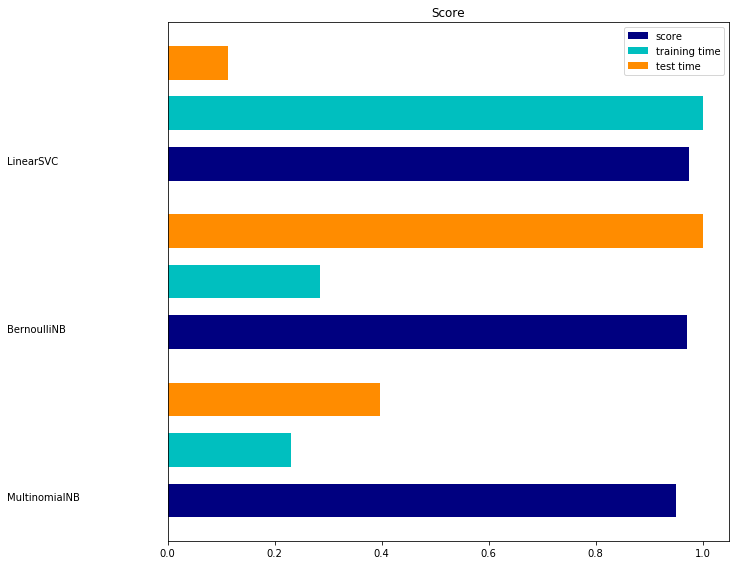

In [8]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
